# Discovering Reinforcement Learning Algorithms

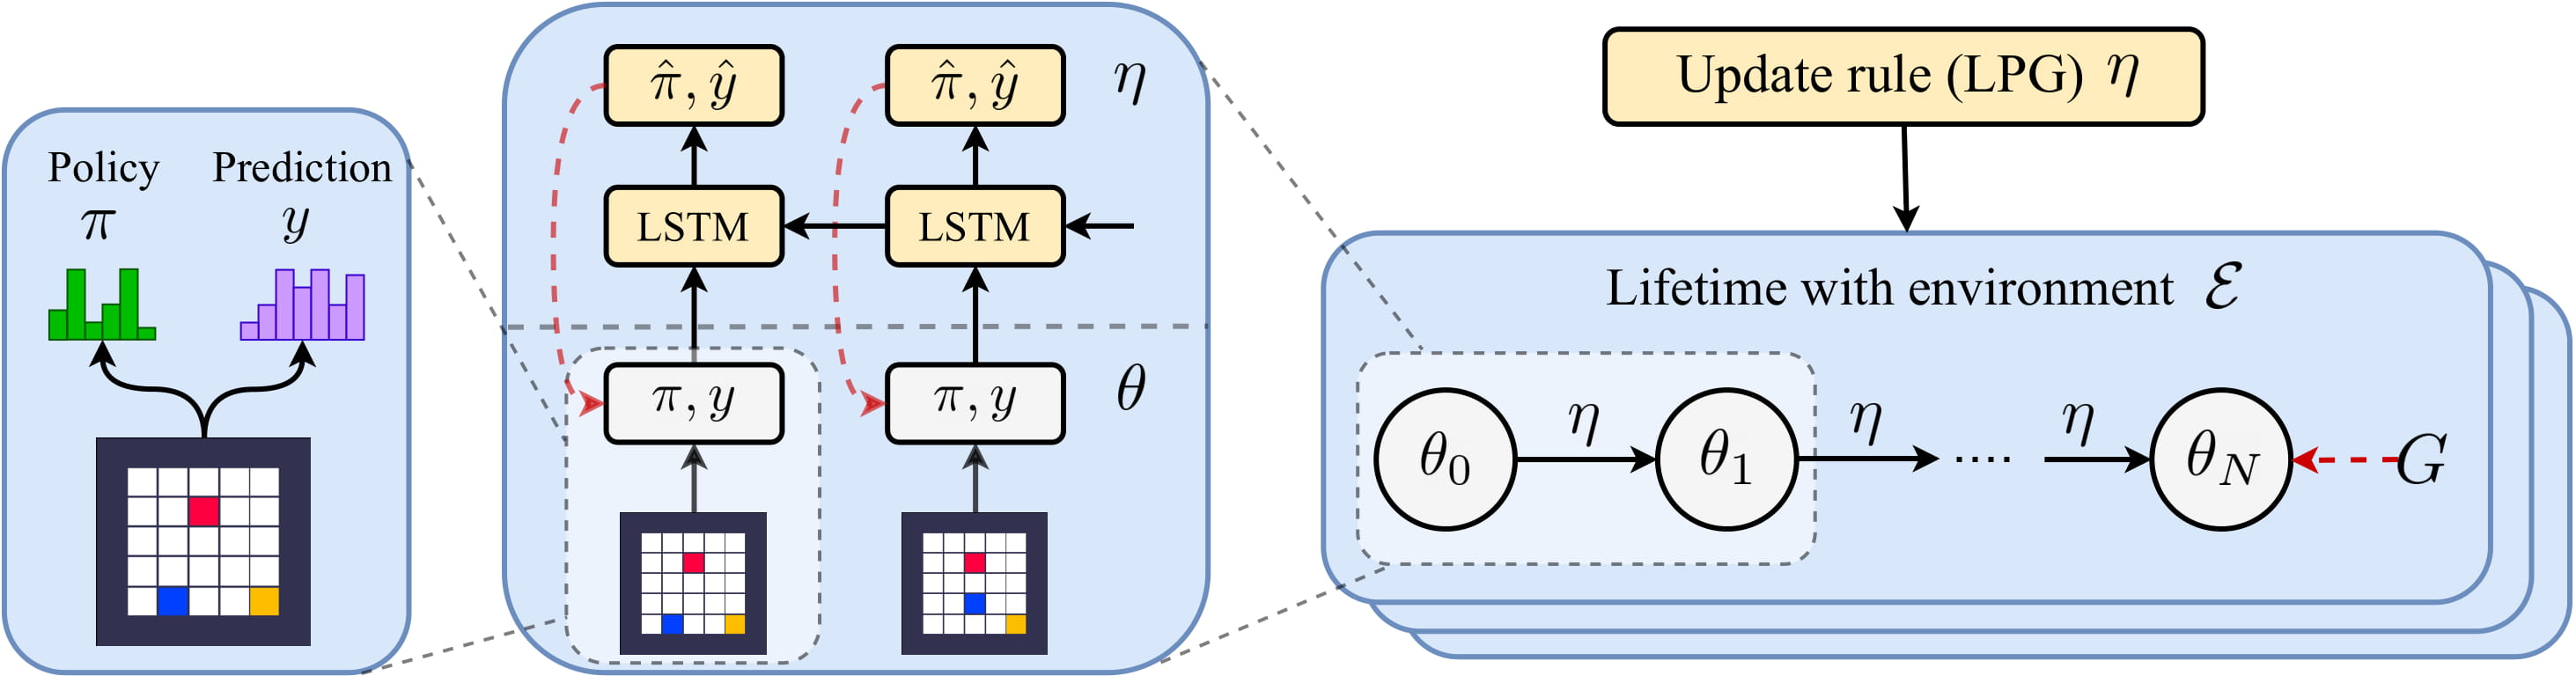

## Meta-Learning Framework for Learned Policy Gradient

$$
\eta^\ast = \argmax_x \mathbb{E}_{\mathcal{E} \sim p(\mathcal{E})} \mathbb{E}_{\theta_0 \sim p(\theta_0)} [G]
$$

$$
G = \mathbb{E}_{\pi_{\theta_N}} \Big[\sum_t^\infty \gamma^t r_t\Big]
$$

* The objective aims to find an update rule $\eta$ such that when it is used to update the agent's parameters until the end of its lifetime $(\theta_0 \rightarrow \cdots \rightarrow \theta_N)$, the agent maximizes the expected return in the given environment.
* The resulting update rule $\eta$ is called Learned Policy Gradient (LPG)

## Agent Update

Agent parameters are updated by performing gradient ascent in the direction of:

$$
\Delta\theta \propto \mathbb{E}_{\pi_\theta}\big[ \nabla_\theta\ \log \pi_\theta(a|s)\hat{\pi} - \alpha_y \nabla_\theta D_{KL}\big(y_\theta(s) \| \hat{y}\big) \big]
$$

where $\hat{\pi}$ and $\hat{y}$ are the output of LPG

Notation | Description
--- | ---
$\hat{\pi}$ and $\hat{y}$| output of LPG
$\hat{\pi}$ | specifies how the action-probability should be adjusted, and has a direct effect on the agent’s behaviour
$\hat{y}$ | specifies a target categorical distribution that the agent should predict for a given state, and does not have an effect on the policy until the LPG discovers useful semantics of it and uses $y$ to indirectly change the policy by bootstrapping
$\alpha_y$ | coefficient for the prediction update

---

**Algorithm 1** Meta-Training of Learned Policy Gradient

---

>**Input**: $p(\mathcal{E})$: Environment distribution, $p(\theta_0)$: Initial agent parameter distribution \
>Initialize meta-parameters $\eta$ and hyperparameter sampling distribution $p(\alpha|\mathcal{E})$ \
>Sample batch of environment-agent-hyperparameters $\{\mathcal{E} \sim p(\mathcal{E}), \theta \sim p(\theta_0), \alpha \sim p(\alpha|\mathcal{E})\}_i$ \
>**repeat** \
>>**for all** lifetimes $\{\mathcal{E}, \theta, \alpha\}_i$ **do** \
>>>Update parameters $\theta$ using $\eta$ and $\alpha$ for $K$ times using Eq. (2) \
>>>Compute meta-gradient using Eq. (4) \
>>>**if** lifetime ended **then** \
>>>>Update hyperparameter sampling distribution $p(\alpha|\mathcal{E})$ \
>>>>Reset lifetime $\mathcal{E} \sim p(\mathcal{E}), \theta \sim p(\theta_0), \alpha \sim p(\alpha|\mathcal{E})$ \

>>>**end if**

>>**end for** \
>>Update meta-parameters $\eta$ using meta-gradients averaged over all lifetimes.

>**until** $\eta$ converges

## LPG Update ($\eta$)

LPG is meta-trained by taking into account how much it improves the performances of a population of
agents interacting with different kinds of environments. Specifically, the meta-gradients are calculated
by applying policy gradient to the objective in Eq. (1) as follows:

$$
\Delta\eta \propto \mathbb{E}_\mathcal{E} \mathbb{E}_{\theta_0} \big[\nabla_\eta \log \pi_{\theta_N}(a|s)G \big]
$$

## Implementation

## 1
>**Input**: $p(\mathcal{E})$: Environment distribution, $p(\theta_0)$: Initial agent parameter distribution

In [10]:
import gym
env = gym.make("Taxi-v3")
print(env.observation_space)
print(env.action_space)

Discrete(500)
Discrete(6)


In [11]:
#@title Policy class
class Policy:
  def __init__(self, n_states, n_actions):
    self.n_states = n_states
    self.n_actions = n_actions
    self.shape = (n_states, n_actions)

  def __call__(self, state):
    return self.get_action_values(state), self.get_state_value(state)

  def get_action_values(self, state):
    return self.π[state]

  def get_state_value(self, state):
    return self.y[state]
    
  def initialize(self, method='normal'):
    if method == 'normal':
      self.π = np.random.normal(size = self.shape)
    elif method == 'random':
      self.π = np.random.random(self.shape)
    elif method == 'zeros':
      self.π = np.zeros(self.shape)
    elif method == 'ones':
      self.π = np.ones(self.shape)
    else:
      raise NotImplementedError()

    self.y = np.random.random(self.n_states)

  def value(self, state, action):
    return self.π[state, action]

  def random_action(self):
    return np.random.randint(0, self.n_actions)

  def best_action(self, state):
    return np.argmax(self.get_action_values(state))

  def epsilon_random_action(self, state, epsilon):
    if np.random.random() < epsilon:
      return self.random_action()
    else:
      return self.best_action(state)

## 2
>Initialize meta-parameters $\eta$ and hyperparameter sampling distribution $p(\alpha|\mathcal{E})$ \

In [12]:
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow as tf

In [13]:
y = Input(shape = (1,))
x = Dense(16, activation = 'relu')(y)
x = Dense(1, activation = 'relu')(x)
EmbeddingLayer = Model(y, x)

inputs = Input(shape = (None, 6))
pi_hat = LSTM(256, activation = 'relu', go_backwards = True)(inputs)
y_hat = LSTM(256, activation = 'relu', go_backwards = True)(inputs)
η = Model(inputs, [pi_hat, y_hat])

## 3
> Sample batch of environment-agent-hyperparameters $\{\mathcal{E} \sim p(\mathcal{E}), \theta \sim p(\theta_0), \alpha \sim p(\alpha|\mathcal{E})\}_i$

In [14]:
class Lifetime:
  def __init__(self, Ɛ, γ):
    self.Ɛ = Ɛ
    self.γ = γ

    self.reset()

  def reset(self):
    self.episode = []

    self.θ = Policy(self.Ɛ.observation_space.n, self.Ɛ.action_space.n)
    self.θ.initialize()

    self.α = np.random.normal(size = self.Ɛ.observation_space.n)

    self.state = self.Ɛ.reset()

  def step(self):
    self.y0 = self.θ.get_state_value(self.state)
    action = self.θ.best_action(self.state)
    self.pi = self.θ.value(self.state, action)
    self.state, reward, done, info = self.Ɛ.step(action)
    self.y1 = self.θ.get_state_value(self.state)
    self.episode.append([reward, float(done), self.γ, self.pi, self.y0, self.y1])
    episode = self.episode

    if done:
      print ("Reached terminal state")
      self.reset()

    return episode

In [15]:
def sample(env_id, γ=0.95, batch_size=32):
  return [Lifetime(gym.make(env_id), γ) for i in range(batch_size)]

# 4
**repeat** \
>**for all** lifetimes $\{\mathcal{E}, \theta, \alpha\}_i$ **do** \
>>Update parameters $\theta$ using $\eta$ and $\alpha$ for $K$ times using Eq. (2) \
>>Compute meta-gradient using Eq. (4) \
>>**if** lifetime ended **then** \
>>>Update hyperparameter sampling distribution $p(\alpha|\mathcal{E})$ \
>>>Reset lifetime $\mathcal{E} \sim p(\mathcal{E}), \theta \sim p(\theta_0), \alpha \sim p(\alpha|\mathcal{E})$ \

>>**end if**

>**end for** \
>Update meta-parameters $\eta$ using meta-gradients averaged over all lifetimes.

**until** $\eta$ converges

In [16]:
batch = sample("Taxi-v3")

In [17]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.00025)

In [ ]:
for step in range(100000):
  for lifetime in batch:
    lifetime.step()

  with tf.GradientTape() as tape:
    KL = tf.keras.losses.KLDivergence()
    losses = []
    for lifetime in batch:
      pi_hat, y_hat = η(tf.expand_dims(lifetime.episode, axis = 0))
      sample_loss = tf.math.log(lifetime.pi * pi_hat + 1e-08) - lifetime.α[lifetime.state] * KL(lifetime.y1, y_hat)
      losses.append(sample_loss)

      loss = tf.reduce_mean(losses)

  grads = tape.gradient(loss, η.trainable_variables)
  optimizer.apply_gradients(zip(grads, η.trainable_variables))

  print ("Loss:", loss.numpy())

Loss: nan
Loss: 303.3985
Loss: 315.61
Loss: 271.463
Loss: 290.82483
Loss: 246.3669
Loss: 256.3072
Loss: 220.27203
Loss: 229.34409
Loss: 179.81752
Loss: 177.20312
Loss: 139.20804
Loss: 135.85336
Loss: 91.70938
Loss: 97.03755
Loss: 77.7162
Loss: 92.73483
Loss: 68.559685
Loss: 76.58499
Loss: 63.645226
Loss: 95.94075
Loss: 73.79584
Loss: 98.366394
Loss: 76.59859
Loss: 97.94016
Loss: 86.6275
Loss: 98.7406
Loss: 79.0023
Loss: 125.21445
Loss: 90.2838
Loss: 103.4117
Loss: 85.532196
Loss: 114.1626
Loss: 86.089615
Loss: 95.98236
Loss: 81.81408
Loss: 102.16666
Loss: 80.250145
Loss: 88.427704
Loss: 68.44719
Loss: 78.11511
Loss: 56.56953
Loss: 63.07278
Loss: 64.71866
Loss: 57.60713
Loss: 54.368248
Loss: 57.250404
Loss: 67.65407
Loss: 60.418396
Loss: 65.11632
Loss: 61.284943
Loss: 66.81331
Loss: 66.40664
